<a href="https://colab.research.google.com/github/Jastej786/Inflation_TimeSeries_Analysis_India/blob/main/Time_series_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [37]:
dataset = pd.read_csv('/content/Inflation_data_india.csv')


In [38]:
dataset.dropna(inplace=True)
dataset.tail(5)

,Date,Inflation
128,2023-09-01,-25.56
129,2023-10-01,12.74
130,2023-11-01,12.61
131,2023-12-01,-10.60
132,2024-01-01,-8.81


In [39]:
df = dataset.copy()

In [40]:
df['Date'] = pd.to_datetime(df['Date'])

In [41]:
df.set_index('Date', inplace=True)

df.head(5)

,Inflation
Date,
2013-02-01,11.39
2013-03-01,1.13
2013-04-01,11.27
2013-05-01,17.86
2013-06-01,36.30


In [42]:
# summary of final DataFrame
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Inflation,132.0,5.471591,18.193749,-50.36,-6.9125,6.985,17.225,79.91


#Visualizing Time Series


<Axes: xlabel='Date'>

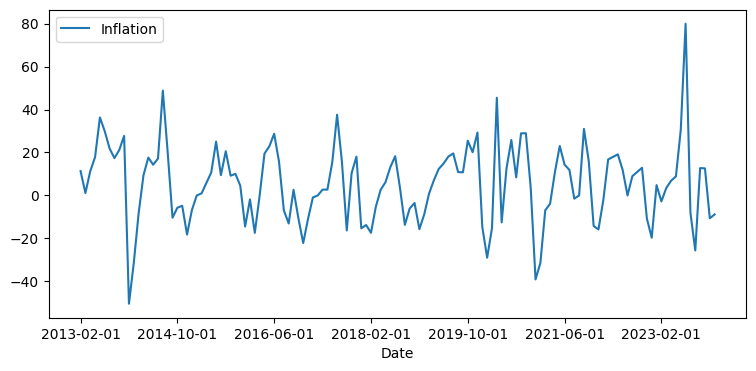

In [30]:
dataset.plot(x='Date', y='Inflation', figsize=(9,4))

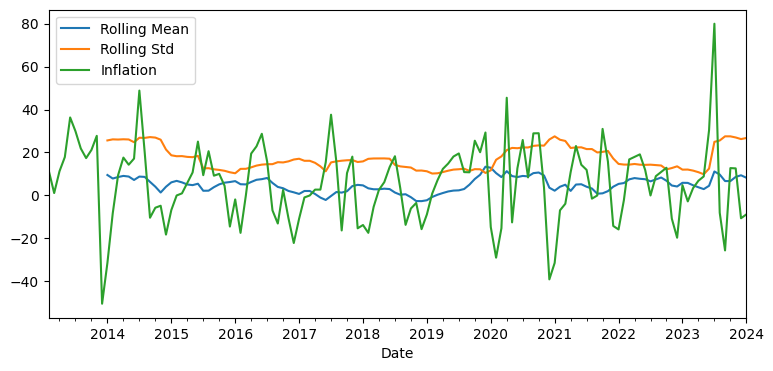

In [43]:
# more time series of inflation percentage
time_series = df['Inflation']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(9,4))
plt.legend()
plt.show()

From this plot we can see Indian inflation is a complex measure. The standard deviation is not flattened and the behaviour seems to be quite dynamic in time.

To understand more about our time series and get more insights for future predicting, we will plot it's decomposition. These components are defined as follows:

observed: the actual value in the series;

trend: the increasing or decreasing value in the series;

seasonality: the repeating short-term cycle or pattern in the series;

residual/noise: the random variation in the series.

In [44]:
type(dataset['Date'][1])

str

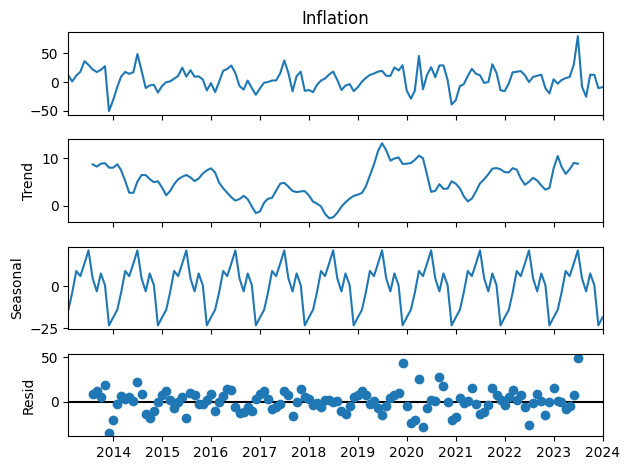

In [45]:
# plot decomposition components
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

#Introduction to ARIMA Model

ARIMA (aka Box-Jenkins) is an acronym that is short for Auto Regressive Integrated Moving Average. It is a class of model that that captures a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any non-seasonal time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models. Seasonal changes or patterns require extending this model into Seasonal ARIMA (SARIMA) by adding seasonal terms. Since inflation in Poland is definitely non-seasonal, this type of model should fit great.

To build an accurate statistical model it is crucial to know its parameters (p, d, q) which are integer values.

The parameters of the ARIMA model are defined as follows:

p: number of lag observations included in the model, also called the lag order (AR term);

d: number of times that the raw observations are differenced, also called the degree of differencing (I term);

q: number of differencing required to make the time series stationary (MA term).

We need to find the value of each term, but before that we must check if our dataset is stationary.

#Identifying if the Data is Stationary

To check if the inflation series is stationary, we will implement the Augmented Dickey Fuller (ADF) test. To identify the nature of data, we will be using the null hypothesis.

The null hypothesis (
) of the ADF test is that the data is non stationary. If the P-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the series is indeed stationary.

So, in other words, if P-value is greater the 0.05 (data is non stationary) we will need to find the order of differencing. Otherwise, we can assign it is equal 0.

In [47]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)

    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['Inflation'])

1. ADF:  -7.713085143766191
2. P-value:  1.2487732963909984e-11
3. Num of Lags:  6
4. Num of Observations:  125
5. Critial Values:
	 1% :  -3.4837793736959997
	 5% :  -2.88495387648
	 10% :  -2.579256976

Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.


P-value is below 0.05 which means our data series is stationary. We can skip finding d term but for this purpose we will show methodology of determining it in the next step

#Differencing - Determining d Order

Using pmdarima package we can easily find value of d term with different tests. Since our time series is stationary, we will still accept d term to be 0 because there is no need of calculating it.

In [51]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['Inflation'], test='adf'))
print(ndiffs(df['Inflation'], test='kpss'))
print(ndiffs(df['Inflation'], test='pp'))

0
0
0


Autocorrelation (ACF) and Partial Autocorrelation (PACF) - Determining p and q Order

Autocorrelation it is a statistic describing the extent to which a given term of the series depends on the previous terms in the time series (with a constant time shift). Partial autocorrelation expresses the correlation between observations made at two points in time while accounting for any influence from other observations.

By plotting ACF and PACF we are able to determine p and q. We can use ACF to determine the optimal number of MA terms and PACF to determine the optimal number of terms to use in the AR model.

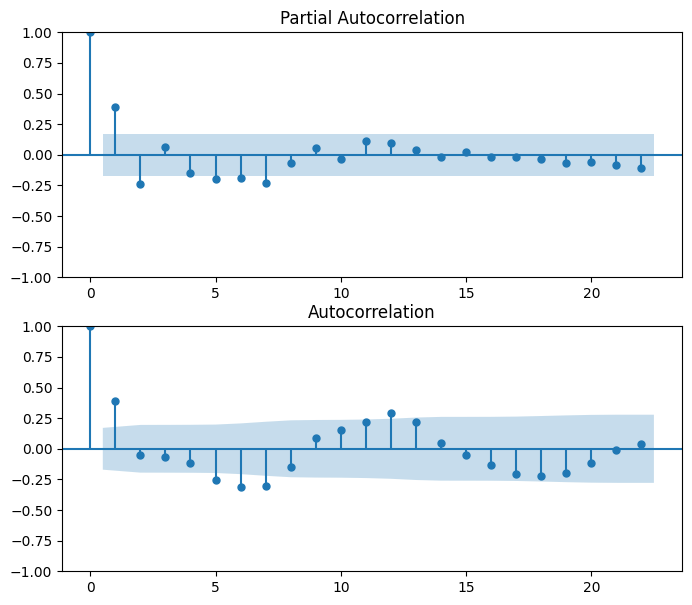

In [52]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

From PACF graph we can determine p is equal 2. The theoretical PACF tapers toward 0 in some manner and partial autocorrelations are equal to 0 beyond that point. The number of non zero partial autocorrelations gives the order of the AR term. Put another way, only the vertical spikes that exceed the horizontal lines are considered significant. We can observe this behaviour on lag 2.

From ACF graph we can determine q order. The autocorrelations are significant for a large number of lags. Perhaps the autocorrelations at lags 2 and above are merely due to the propagation of the autocorrelation at lag 1, which is confirmed by the PACF plot. We will accept q as 1.

# Auto ARIMA Function to Find Best Order for Model

Auto ARIMA is another function which can help us find the best fit and determine our three parameters in an automatic way. It uses a stepwise approach to search multiple combinations of (p, d, q) terms and chooses the best model that has the least AIC. For this task we will again use pmdarima module. We will just demonstrate it and not implement its results for final model.

In [54]:
# auto ARIMA function
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Inflation'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1114.014, Time=1.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1143.481, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1123.752, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1115.647, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1152.993, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1119.234, Time=0.37 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1115.408, Time=1.22 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1117.647, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1120.913, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1121.232, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1125.843, Time=0.11 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -551.007
Date:                Sat, 13 Jul 2024   AIC                           1114.014
Time:                        19:09:08   BIC                           1131.311
Sample:                    02-01-2013   HQIC                          1121.042
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2336      0.775      1.592      0.111      -0.285       2.752
ar.L1          0.9820      0.183      5.366      0.000       0.623       1.341
ar.L2         -0.2224      0.172     -1.291      0.197      -0.560       0.115
ma.L1         -0.5355      0.182     -2.936      0.003      -0.893      -0.178
ma.L2         -0.3402      0.179     -1.906      0.057      -0.690       0.010
sigma2       246.0925     23.441     10.499      0.000     200.150     292.035
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.22
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Developing the ARIMA Model

Now, that we determined and know the values of our order, we can finally implement it to ARIMA model

In [57]:
# p=2, d=0, q=2
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Inflation'], order=(2,0,2))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Inflation   No. Observations:                  132
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -551.007
Date:                Sat, 13 Jul 2024   AIC                           1114.014
Time:                        19:16:07   BIC                           1131.311
Sample:                    02-01-2013   HQIC                          1121.042
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1316      0.962      5.335      0.000       3.246       7.017
ar.L1          0.9821      0.183      5.366      0.000       0.623       1.341
ar.L2         -0.2225      0.172     -1.291      0.197      -0.560       0.115
ma.L1         -0.5355      0.182     -2.936      0.003      -0.893      -0.178
ma.L2         -0.3402      0.179     -1.905      0.057      -0.690       0.010
sigma2       246.0950     23.441     10.499      0.000     200.152     292.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.22
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
# predict values
pred = model_fit.predict(start=0, end=len(df) - 1, typ='levels', dynamic=False)

In [59]:
pred.tail()

2023-09-01   -24.534066
2023-10-01    -7.984291
2023-11-01     8.682577
2023-12-01     1.629456
2024-01-01    -6.768715
Freq: MS, Name: predicted_mean, dtype: float64

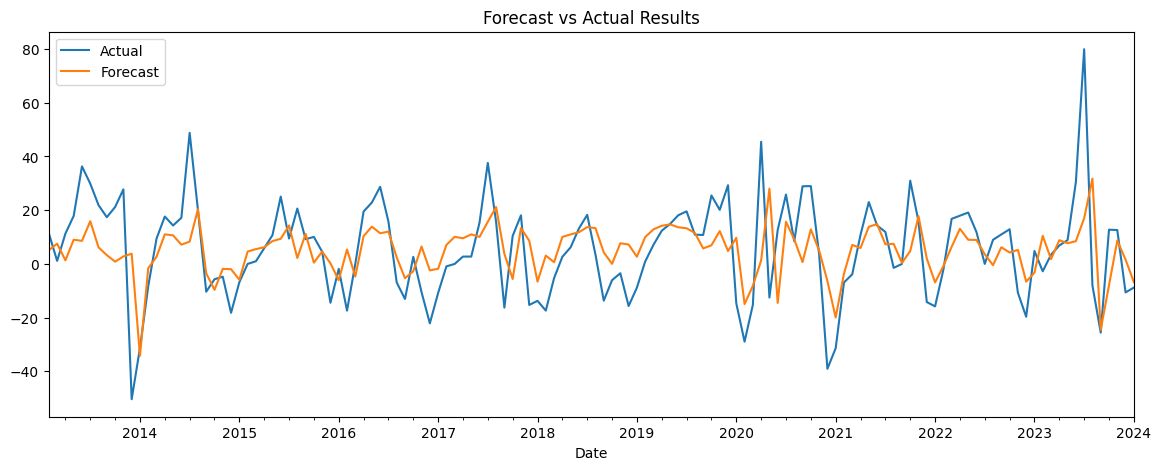

In [61]:
# plot results
df['Inflation'].plot(legend=True, label='Actual', figsize=(14,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

#Accuracy Metrics and Measure Performance of Fitted Model

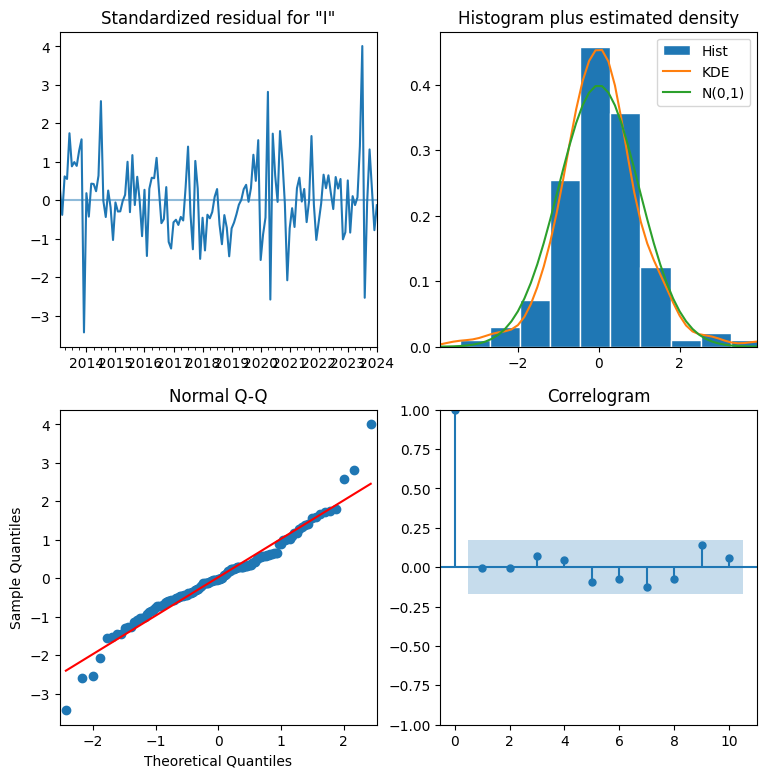

In [62]:
# diagnostic plots for standardized residuals of one endogenous variable
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

Top left plot: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top right plot: The density plot suggest normal distribution with mean around zero.

Bottom left plot: All the markers should lay perfectly on the red line. Any significant deviations would imply the distribution is skewed.

Bottom right plot: The correlogram shows the residual errors are not autocorrelated. Any autocorrelation would suggest that there is some pattern in the residual errors which are not explained in the model.

Overall, these figures do not signal any anomalies and the fit is good.

In [64]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(pred, df['Inflation'], squared=False)
rmse

15.711012982832465

In [65]:
# mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred, df['Inflation'])
mae

11.383501515176432

In [68]:
# mean absolute percentage error
mape = np.mean(np.abs(df['Inflation'] - pred) / df['Inflation']) * 100
mape

inf

In [69]:
# correlation
corr = np.corrcoef(pred, df['Inflation'])[0,1]
corr

0.4991409306142132

#Extrapolating Future Inflation Data

In [72]:
# predict values
forecast = model_fit.predict(start=0, end=len(df) + 6, typ='levels', dynamic=False)

In [73]:
# display forecasted values
forecast.tail(5)

2024-04-01    5.195654
2024-05-01    5.428848
2024-06-01    5.409267
2024-07-01    5.338161
2024-08-01    5.272686
Freq: MS, Name: predicted_mean, dtype: float64

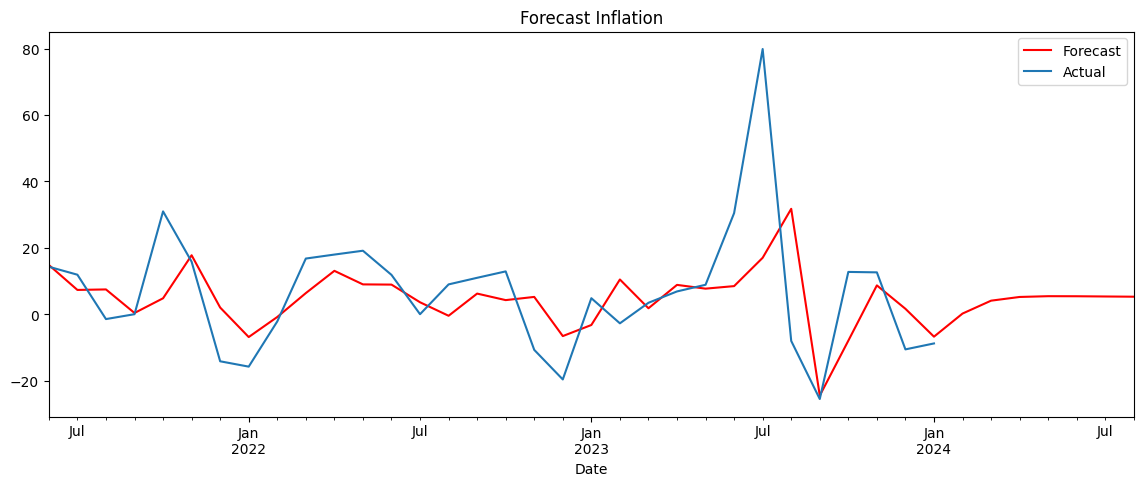

In [78]:
# final plot
forecast.iloc[100:].plot(legend=True, label='Forecast', figsize=(14,5), color='red')
df['Inflation'].iloc[100:].plot(legend=True, label='Actual')
plt.title('Forecast Inflation')
plt.show()